1a

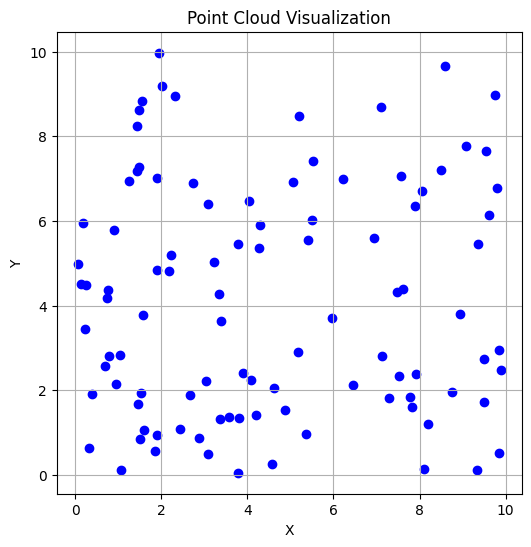

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_point_cloud(file_path):
   
    points = np.loadtxt(file_path, skiprows=1)
    
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    
    plt.figure(figsize=(6,6))
    plt.scatter(x_coords, y_coords, color='blue', marker='o')
    plt.title("Point Cloud Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    visualize_point_cloud('mesh.dat')


1b and 1c

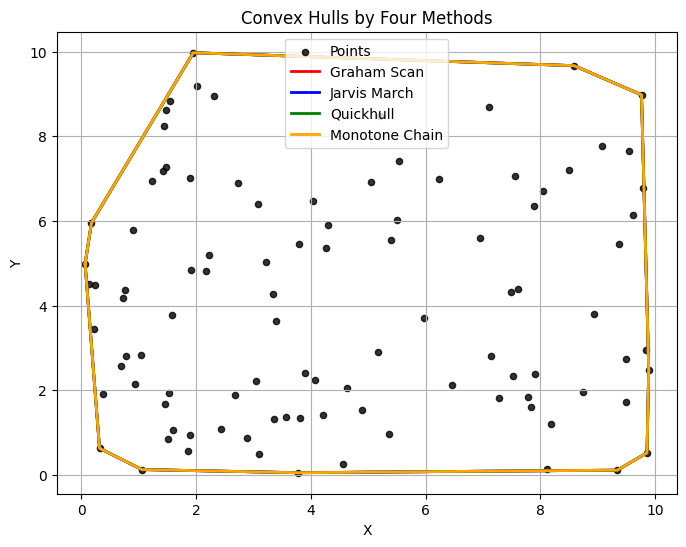

In [9]:
import numpy as np
import matplotlib.pyplot as plt

########################
# Cross product for 2D
########################
def cross_2d(a, b):
    return a[0]*b[1] - a[1]*b[0]

########################
# 2D Graham Scan
########################
def graham_scan(points):
    points = np.array(points)
    # Sort by y, then by x
    points = points[np.lexsort((points[:, 0], points[:, 1]))]
    p0 = points[0]
    
    def polar_angle(p):
        return np.arctan2(p[1] - p0[1], p[0] - p0[0])
    sorted_points = sorted(points[1:], key=polar_angle)
    
    hull = [p0, sorted_points[0]]
    for p in sorted_points[1:]:
        while len(hull) > 1:
            cross_val = cross_2d(hull[-1] - hull[-2], p - hull[-1])
            if cross_val <= 0:
                hull.pop()
            else:
                break
        hull.append(p)
    return np.array(hull)

########################
# 2D Jarvis March
########################
def jarvis_march(points):
    points = np.array(points)
    start_index = np.argmin(points[:, 0])
    hull = []
    current_index = start_index
    
    while True:
        hull.append(points[current_index])
        next_index = (current_index + 1) % len(points)
        for i in range(len(points)):
            cross_val = cross_2d(points[next_index] - points[current_index],
                                 points[i] - points[current_index])
            if cross_val < 0:
                next_index = i
            elif cross_val == 0:
                # If collinear, pick the farther point
                dist_i = np.linalg.norm(points[i] - points[current_index])
                dist_next = np.linalg.norm(points[next_index] - points[current_index])
                if dist_i > dist_next:
                    next_index = i
        current_index = next_index
        if current_index == start_index:
            break
    return np.array(hull)

########################
# 2D Quickhull
########################
def quickhull(points):
    points = np.array(points)

    def point_line_dist(a, b, p):
        cross_val = cross_2d(b - a, p - a)
        return abs(cross_val) / np.linalg.norm(b - a)
    
    def quickhull_recursive(a, b, pts):
        if pts.shape[0] == 0:
            return []
        # Find farthest point p
        distances = np.array([point_line_dist(a, b, pt) for pt in pts])
        p_index = np.argmax(distances)
        p = pts[p_index]
        
        left_ap = []
        left_pb = []
        for i, pt in enumerate(pts):
            if i == p_index:
                continue
            cross1 = cross_2d(p - a, pt - a)
            cross2 = cross_2d(b - p, pt - p)
            if cross1 > 0:
                left_ap.append(pt)
            if cross2 > 0:
                left_pb.append(pt)
        
        hull_ap = quickhull_recursive(a, p, np.array(left_ap))
        hull_pb = quickhull_recursive(p, b, np.array(left_pb))
        
        return hull_ap + [p] + hull_pb

    # Find leftmost and rightmost
    min_x_index = np.argmin(points[:, 0])
    max_x_index = np.argmax(points[:, 0])
    A = points[min_x_index]
    B = points[max_x_index]

    left_set, right_set = [], []
    for i, pt in enumerate(points):
        if i in (min_x_index, max_x_index):
            continue
        cross_val = cross_2d(B - A, pt - A)
        if cross_val > 0:
            left_set.append(pt)
        elif cross_val < 0:
            right_set.append(pt)

    left_hull = quickhull_recursive(A, B, np.array(left_set))
    right_hull = quickhull_recursive(B, A, np.array(right_set))
    hull = [A] + left_hull + [B] + right_hull
    return np.array(hull)

########################
# 2D Monotone Chain
########################
def monotone_chain(points):
    points = np.array(points)
    points = points[np.lexsort((points[:, 1], points[:, 0]))]
    
    lower = []
    for p in points:
        while len(lower) >= 2:
            cross_val = cross_2d(lower[-1] - lower[-2], p - lower[-1])
            if cross_val <= 0:
                lower.pop()
            else:
                break
        lower.append(p)
    
    upper = []
    for p in reversed(points):
        while len(upper) >= 2:
            cross_val = cross_2d(upper[-1] - upper[-2], p - upper[-1])
            if cross_val <= 0:
                upper.pop()
            else:
                break
        upper.append(p)
    
    lower.pop()
    upper.pop()
    hull = np.concatenate([lower, upper])
    return hull

########################
# Plotting function
########################
def plot_hull(hull_points, color, label):
    # Close the hull by appending the first point
    hull_closed = np.vstack([hull_points, hull_points[0]])
    plt.plot(hull_closed[:, 0], hull_closed[:, 1], color=color, linewidth=2, label=label)

########################
# Main script
########################
def main():
    # Load the point cloud from a .dat file (skip header if needed)
    points = np.loadtxt("mesh.dat", skiprows=1)  # adjust skiprows if no header
    
    # Plot original points
    plt.figure(figsize=(8,6))
    plt.scatter(points[:,0], points[:,1], color='black', s=20, alpha=0.8, label='Points')
    
    # Compute hulls
    hull_graham = graham_scan(points)
    hull_jarvis = jarvis_march(points)
    hull_quick = quickhull(points)
    hull_mono = monotone_chain(points)
    
    # Plot each hull in a different color
    plot_hull(hull_graham, 'red', 'Graham Scan')
    plot_hull(hull_jarvis, 'blue', 'Jarvis March')
    plot_hull(hull_quick, 'green', 'Quickhull')
    plot_hull(hull_mono, 'orange', 'Monotone Chain')
    
    plt.title("Convex Hulls by Four Methods")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


2a

In [11]:
import numpy as np

def generate_point_cloud(n):
    points = np.random.rand(n, 2)
    return points

#test
if __name__ == "__main__":
    n = 1000
    point_cloud = generate_point_cloud(n)
    print(point_cloud[:5])  # Print first 5 points to verify


[[0.1300194  0.03135921]
 [0.09015483 0.40221377]
 [0.78059912 0.9430183 ]
 [0.22932222 0.30259877]
 [0.39159228 0.25030288]]


2b

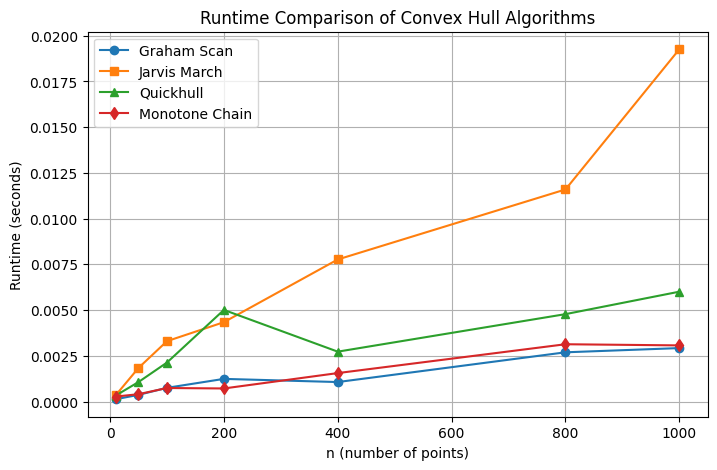

In [19]:
import time
import matplotlib.pyplot as plt

def measure_runtimes():
    # Values of n to test
    n_values = [10, 50, 100, 200, 400, 800, 1000]

    # Lists to store runtimes for each algorithm
    times_graham = []
    times_jarvis = []
    times_quickhull = []
    times_monotone = []

    for n in n_values:
        # 1) Generate the point cloud
        points = generate_point_cloud(n)

        # 2) Graham Scan
        start = time.time()
        _ = graham_scan(points)
        end = time.time()
        times_graham.append(end - start)

        # 3) Jarvis March
        start = time.time()
        _ = jarvis_march(points)
        end = time.time()
        times_jarvis.append(end - start)

        # 4) Quickhull
        start = time.time()
        _ = quickhull(points)
        end = time.time()
        times_quickhull.append(end - start)

        # 5) Monotone Chain
        start = time.time()
        _ = monotone_chain(points)
        end = time.time()
        times_monotone.append(end - start)

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(n_values, times_graham, marker='o', label='Graham Scan')
    plt.plot(n_values, times_jarvis, marker='s', label='Jarvis March')
    plt.plot(n_values, times_quickhull, marker='^', label='Quickhull')
    plt.plot(n_values, times_monotone, marker='d', label='Monotone Chain')

    plt.xlabel('n (number of points)')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime Comparison of Convex Hull Algorithms')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    measure_runtimes()

def write_conclusion_to_file(filename, text):
    with open(filename, 'w') as f:
        f.write(text)

conclusion_text = """
Conclusion on Convex Hull Algorithm Performance:

1. Monotone Chain (O(n log n)) remains quite efficient for all tested n.
2. Graham Scan (O(n log n)) grows similarly, though slightly higher than Monotone Chain in the data.
3. Quickhull, typically O(n log n), shows more variation but remains moderately fast for random data.
4. Jarvis March (O(nh)) can approach O(n^2) when many points lie on the hull, making it the slowest at n=1000.

Overall, the results align with theoretical complexities:
- Monotone Chain and Graham Scan scale reliably with n log n complexity.
- Jarvis March can degrade if the hull is large.
- Quickhull is usually good, but can degrade in the worst case.

All runtimes remain under 0.02 seconds at n=1000, indicating that for moderate n, any of these methods is practically feasible.
"""

write_conclusion_to_file("convex_hull_conclusion.txt", conclusion_text)


2c

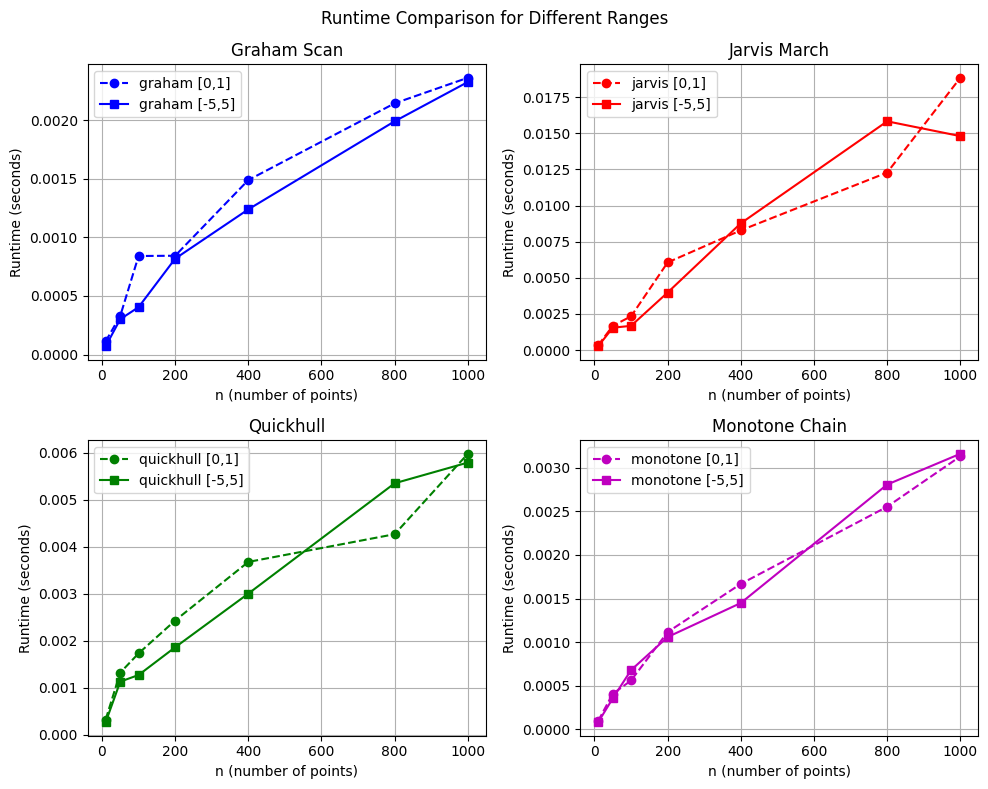

Conclusion has been written to 'range_comparison_conclusion.txt'.


In [16]:
import time
import matplotlib.pyplot as plt
import numpy as np

def generate_point_cloud_in_range(n, low, high):
    
    return np.random.uniform(low, high, size=(n, 2))
def measure_runtimes_compare():
    # Values of n to test
    n_values = [10, 50, 100, 200, 400, 800, 1000]

    # Dictionaries to store runtimes for each algorithm and each range
    runtimes_01 = {
        'graham': [],
        'jarvis': [],
        'quickhull': [],
        'monotone': []
    }
    runtimes_55 = {
        'graham': [],
        'jarvis': [],
        'quickhull': [],
        'monotone': []
    }

    for n in n_values:
        # 1) Generate point clouds
        points_01 = generate_point_cloud_in_range(n, 0, 1)
        points_55 = generate_point_cloud_in_range(n, -5, 5)

        # 2) Time each algorithm on [0,1] data
        start = time.time()
        _ = graham_scan(points_01)
        runtimes_01['graham'].append(time.time() - start)

        start = time.time()
        _ = jarvis_march(points_01)
        runtimes_01['jarvis'].append(time.time() - start)

        start = time.time()
        _ = quickhull(points_01)
        runtimes_01['quickhull'].append(time.time() - start)

        start = time.time()
        _ = monotone_chain(points_01)
        runtimes_01['monotone'].append(time.time() - start)

        # 3) Time each algorithm on [-5,5] data
        start = time.time()
        _ = graham_scan(points_55)
        runtimes_55['graham'].append(time.time() - start)

        start = time.time()
        _ = jarvis_march(points_55)
        runtimes_55['jarvis'].append(time.time() - start)

        start = time.time()
        _ = quickhull(points_55)
        runtimes_55['quickhull'].append(time.time() - start)

        start = time.time()
        _ = monotone_chain(points_55)
        runtimes_55['monotone'].append(time.time() - start)

    # 4) Plot the results
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Runtime Comparison for Different Ranges')

    # Helper function to plot each algorithm’s data
    def plot_algorithm(ax, algo_name, color):
        ax.plot(n_values, runtimes_01[algo_name], color + 'o--', label=f'{algo_name} [0,1]')
        ax.plot(n_values, runtimes_55[algo_name], color + 's-', label=f'{algo_name} [-5,5]')
        ax.set_xlabel('n (number of points)')
        ax.set_ylabel('Runtime (seconds)')
        ax.legend()
        ax.grid(True)

    # Subplot for each algorithm
    plot_algorithm(axes[0,0], 'graham', 'b')
    axes[0,0].set_title('Graham Scan')

    plot_algorithm(axes[0,1], 'jarvis', 'r')
    axes[0,1].set_title('Jarvis March')

    plot_algorithm(axes[1,0], 'quickhull', 'g')
    axes[1,0].set_title('Quickhull')

    plot_algorithm(axes[1,1], 'monotone', 'm')
    axes[1,1].set_title('Monotone Chain')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    measure_runtimes_compare()

def write_conclusion_to_file(filename, text):
    with open(filename, 'w') as f:
        f.write(text)

conclusion_text = """
Conclusion on Ranges [0,1] vs. [-5,5]:

1. All four algorithms show similar growth trends in both ranges, indicating their 
   underlying time complexities (O(n log n) or O(nh)) remain the main factor.

2. Jarvis March exhibits a larger runtime difference at higher n. Since it's O(nh), 
   if the hull is bigger (which can happen more often in [-5,5]), the algorithm does more work.

3. Graham Scan, Quickhull, and Monotone Chain do not show as large a variance 
   because they are typically O(n log n) and less sensitive to hull size.

4. Overall, the difference in runtime due to range alone is modest for most algorithms, 
   but distributions that increase hull size can cause noticeable slowdowns, 
   especially for Jarvis March.

Hence, while the bounding box changes the spread of points, the biggest impact on runtime 
is still each algorithm's theoretical complexity and how many points end up on the hull.
"""

write_conclusion_to_file("range_comparison_conclusion.txt", conclusion_text)
print("Conclusion has been written to 'range_comparison_conclusion.txt'.")



2. d

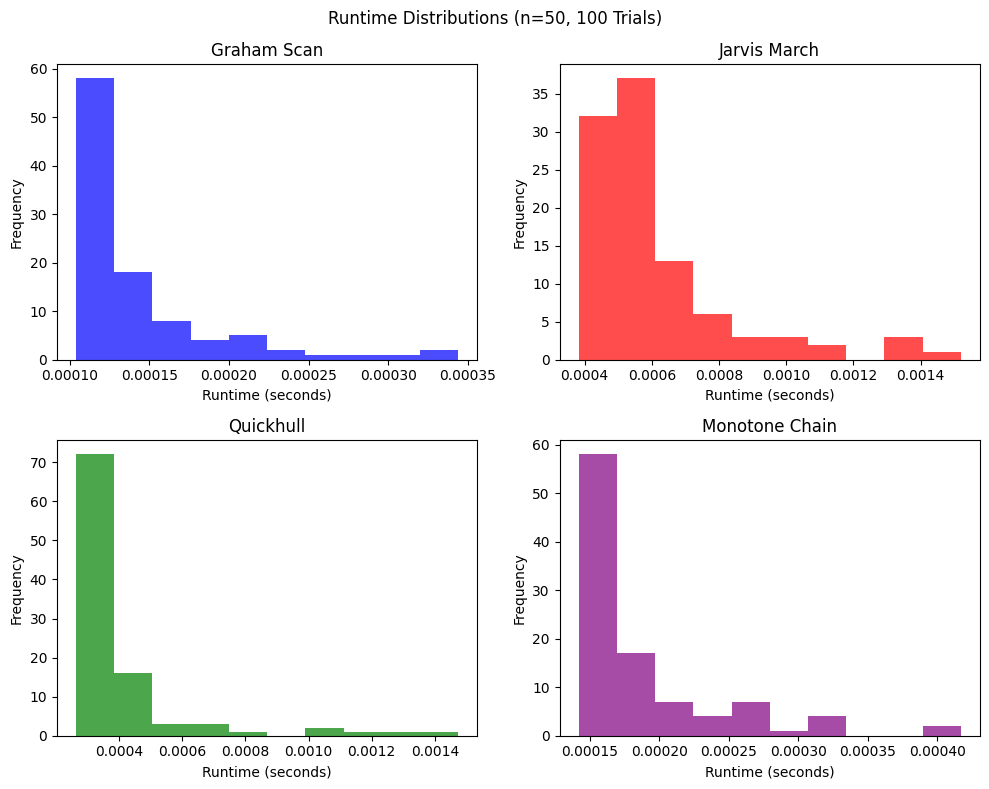

Conclusion has been written to 'distribution_conclusion.txt'.


In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(42)

def generate_point_cloud(n):
    
    return np.random.rand(n, 2)

def measure_distribution(n=50, trials=100):
   
    # Lists to store 100 runtime measurements for each algorithm
    times_graham = []
    times_jarvis = []
    times_quickhull = []
    times_monotone = []

    for _ in range(trials):
        # Generate a new point cloud of size n=50
        points = generate_point_cloud(n)

        # Graham Scan
        start = time.time()
        _ = graham_scan(points)
        times_graham.append(time.time() - start)

        # Jarvis March
        start = time.time()
        _ = jarvis_march(points)
        times_jarvis.append(time.time() - start)

        # Quickhull
        start = time.time()
        _ = quickhull(points)
        times_quickhull.append(time.time() - start)

        # Monotone Chain
        start = time.time()
        _ = monotone_chain(points)
        times_monotone.append(time.time() - start)

    # Plot 4 histograms
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Runtime Distributions (n=50, 100 Trials)')

    # 1) Graham Scan
    axes[0,0].hist(times_graham, bins=10, color='blue', alpha=0.7)
    axes[0,0].set_title('Graham Scan')
    axes[0,0].set_xlabel('Runtime (seconds)')
    axes[0,0].set_ylabel('Frequency')

    # 2) Jarvis March
    axes[0,1].hist(times_jarvis, bins=10, color='red', alpha=0.7)
    axes[0,1].set_title('Jarvis March')
    axes[0,1].set_xlabel('Runtime (seconds)')
    axes[0,1].set_ylabel('Frequency')

    # 3) Quickhull
    axes[1,0].hist(times_quickhull, bins=10, color='green', alpha=0.7)
    axes[1,0].set_title('Quickhull')
    axes[1,0].set_xlabel('Runtime (seconds)')
    axes[1,0].set_ylabel('Frequency')

    # 4) Monotone Chain
    axes[1,1].hist(times_monotone, bins=10, color='purple', alpha=0.7)
    axes[1,1].set_title('Monotone Chain')
    axes[1,1].set_xlabel('Runtime (seconds)')
    axes[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return {
        'graham': times_graham,
        'jarvis': times_jarvis,
        'quickhull': times_quickhull,
        'monotone': times_monotone
    }

if __name__ == "__main__":
    results = measure_distribution(n=50, trials=100)
def write_conclusion_to_file(filename, text):
    with open(filename, 'w') as f:
        f.write(text)

conclusion_text = """
Conclusion on Runtime Distributions (n=50, 100 Trials):

1. All algorithms are quite fast at n=50; most runs complete in a fraction of a millisecond.
2. Histograms show a typical right-skewed distribution, where most runs cluster at low runtime,
   but a few outliers take longer.
3. Jarvis March can exhibit a broader tail, reflecting its O(nh) complexity
   (it can approach O(n^2) when many points lie on the hull).
4. Graham Scan, Quickhull, and Monotone Chain all remain near O(n log n),
   so their runtime distributions are relatively tight.

Overall, for n=50, differences among the algorithms are modest, but Jarvis March
does show occasional slower runs compared to the others.
"""

def write_conclusion_to_file(filename, text):
    with open(filename, 'w') as f:
        f.write(text)

conclusion_text = """
Conclusion on Runtime Distributions (n=50, 100 Trials):

1. All algorithms are quite fast at n=50; most runs complete in a fraction of a millisecond.
2. Histograms show a typical right-skewed distribution, where most runs cluster at low runtime,
   but a few outliers take longer.
3. Jarvis March can exhibit a broader tail, reflecting its O(nh) complexity
   (it can approach O(n^2) when many points lie on the hull).
4. Graham Scan, Quickhull, and Monotone Chain all remain near O(n log n),
   so their runtime distributions are relatively tight.

Overall, for n=50, differences among the algorithms are modest, but Jarvis March
does show occasional slower runs compared to the others.
"""

write_conclusion_to_file("distribution_conclusion.txt", conclusion_text)
print("Conclusion has been written to 'distribution_conclusion.txt'.")

